In [5]:
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install pandas
!pip install scikit-learn
!pip install networkx
!pip iinstall ripser
!pip install persim
!pip3 install torch torchvision torchaudio


ERROR: unknown command "iinstall" - maybe you meant "install"


In [6]:
!pip install ripser

In [26]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.colors as colors

import ripser
import persim

from scipy.sparse import csr_matrix
import torch
import os

In [8]:
data = pd.read_csv('Papers/Connectome of an insect brain/Supplementary-Data-S1/all-all_connectivity_matrix.csv')
data = data.set_index('Unnamed: 0')
data.columns = data.columns.astype(int)


In [9]:

# Assuming the dataframe is stored in the variable 'data'
# Remove the first column if it contains row indices
if 'Unnamed: 0' in data.columns:
    data = data.drop(columns=['Unnamed: 0'])

# Convert the dataframe to a dictionary
adjacency_dict = data.to_dict()

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
G.add_nodes_from(adjacency_dict.keys())

# Add edges to the graph
for source_node, target_nodes in adjacency_dict.items():
    for target_node, weight in target_nodes.items():
        if weight == 0:
            continue
        G.add_edge(source_node, target_node, weight=weight)

# Print the graph
print(G)


Graph with 2952 nodes and 96527 edges

In [10]:
def weight_hist(G):
    G_weights = [e[2]['weight'] for e in G.edges.data()]

    fig, ax = plt.subplots(figsize=(10, 7))  # Create a single plot

    # plot weight histogram
    ax.hist(G_weights, bins=100, facecolor='g', alpha=0.75)
    ax.set_title("Weight Histograms")
    ax.set_xlabel("Weight")
    ax.set_ylabel("Counts")
    ax.grid()

    plt.show()

Plot graph and weight histogram

In [11]:
# edge weights
# weight_hist(G)
len([e[2]['weight'] for e in G.edges.data() if e[2]['weight'] <= 1])

46597

In [12]:
nn_weights = torch.load('./data/train_10k_test_1.67k_layer_1.pt')
nn_adj = nn_weights.numpy()

# filter the weights, setting everything above 10 to zero
# nn_adj = ( (nn_adj * (nn_adj < 10)) * (nn_adj >= 1)) * 100
# nn_adj *= (nn_adj < 10)
nn_adj *= 50
nn_adj *= (nn_adj >= 1)
          

G_prime = nx.from_numpy_array(nn_adj)
# weight_hist(G_prime)

In [13]:
def diagram_sizes(dgms):
    return ", ".join([f"|$H_{i}$|={len(d)}" for i, d in enumerate(dgms)])

def persistence_diagram(G, plot=True):
    adj = nx.adjacency_matrix(G)
    A = csr_matrix(adj)
    dgms = ripser.ripser(A, distance_matrix=True, maxdim=1)['dgms']
    if plot:
        persim.plot_diagrams(
            dgms, show=True,
            title=f"PD of SF graph\n{diagram_sizes(dgms)}"
        )
    return dgms

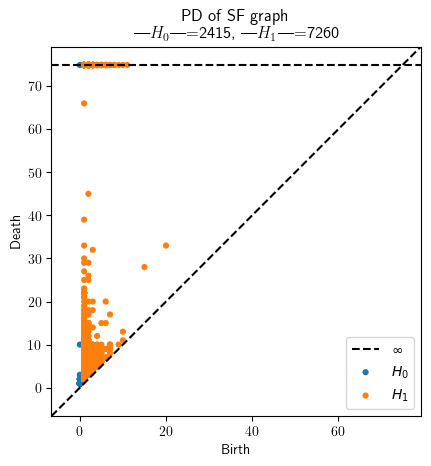

In [14]:
ctm_persistance = persistence_diagram(G)

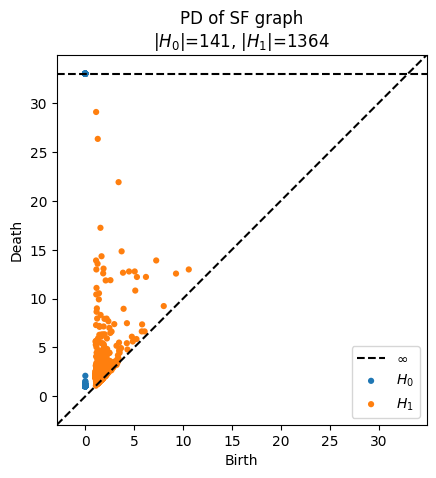

In [15]:
snn_persistance = persistence_diagram(G_prime)

# Distance Time!

In [19]:
# uh for some reason, the ctm_persistance has inf values?
# so like. remove all those values.
ctm_persistance = [dgm[~np.isinf(dgm[:, 1])] for dgm in ctm_persistance]


In [20]:
persim.sliced_wasserstein(ctm_persistance[1], snn_persistance[1])

4862.9768607562955

In [ ]:
distance_bottleneck = persim.bottleneck(ctm_persistance[1], snn_persistance[1], matching=False)
distance_bottleneck

In [ ]:
persim.heat(ctm_persistance[1], snn_persistance[1])

In [ ]:
!pip install rich
from rich import print, inspect
from rich.progress import track

In [27]:
# load all the training steps
# THIS CODE IS NOW INVALID
PATH = "./data/steps/"

def load_snn_training_step(path):
    nn_weights = torch.load(path)
    nn_adj = nn_weights.numpy()
    nn_adj *= 50
    # nn_adj *= (nn_adj >= 1)
    return nx.from_numpy_array(nn_adj)

steps = [load_snn_training_step(PATH + x) for x in os.listdir(PATH)]

In [ ]:
persists = []
for step in track(steps):
    persists.append(persistence_diagram(step))

In [30]:
# get the distance between the first step and all the other steps,
# using sliced wassestein



distances = [persim.bottleneck(ctm_persistance[1], p[1], matching=False) for p in persists]
distances




KeyboardInterrupt: 

### -> Switch to new data format

In [39]:
# load the .pt file with all the training steps
PATH = "/Users/huxley/dataset_storage/snn_tda_mats/adjacency_stack.pt"
all_steps = torch.load(PATH)

print(len(all_steps))

313

In [ ]:
# seperate into a list of adjacency matrices
list_steps = [x.numpy() for x in all_steps]

persists = []
for i in track(range(0, len(list_steps), 10)):
    step = list_steps[i]

    step *= 50
    step *= (step >= 1)

    step = nx.from_numpy_array(step)

    persists.append(persistence_diagram(step, plot=False))
    print(i)

In [ ]:
persim.plot_diagrams(persists[0], show=True)

In [50]:
# compare the first persist with all the others, using slices wasserstein
distances = [persim.sliced_wasserstein(persists[0][1], p[1]) for p in persists]
distances

/Users/huxley/miniconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:984: RuntimeWarning: invalid value encountered in subtract
  l1_diff = abs(u - v)


[0.0,
 175068285.46627188,
 175074190.2121664,
 175075061.03118348,
 175072010.37508565,
 175071443.61241528,
 175074551.2115229,
 175071917.16665968,
 175075916.30021644,
 175081016.1543585,
 175090719.97723803,
 175103822.4433954,
 175114469.25773555,
 175134601.99625745,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [ ]:
# compare the persists with the connectome
distances = [persim.sliced_wasserstein(ctm_persistance[1], p[1]) for p in persists]

***

***


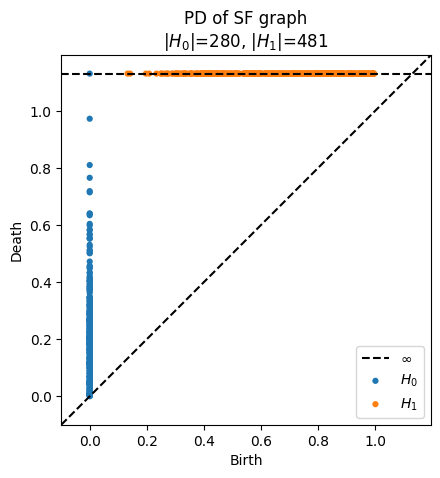

In [33]:
n = nn_adj.shape[0]
from scipy.sparse import random

# Generate a random sparse 3x3 matrix
matrix = random(n, n, density=0.01).toarray()
G_random = nx.from_numpy_array(matrix)
persistence_diagram(G_random)


Complexity analysis:
200 - 0.9 s
300 - 2.9 s
400 - 7.3 s
500 - 24.7 s
600 - 98.1 s

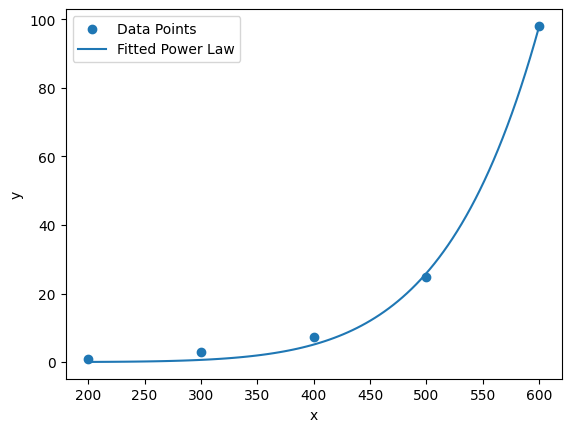

In [9]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the power law function
def power_law(x, a, b):
    return a * np.power(x, b)

# Define the data points
x = np.array([200, 300, 400, 500, 600])  # x values
y = np.array([0.9, 2.9, 7.4, 24.7, 98.1])  # y values

# Fit the power law function to the data points
params, _ = curve_fit(power_law, x, y, p0 = [1, 1], maxfev=10000)

# Extract the fitted parameters
a_fit, b_fit = params

# Generate the fitted curve
x_fit = np.linspace(min(x), max(x), 100)
y_fit = power_law(x_fit, a_fit, b_fit)

# Plot the data points and the fitted curve
plt.scatter(x, y, label='Data Points')
plt.plot(x_fit, y_fit, label='Fitted Power Law')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


In [10]:
print(params)

[5.50509522e-19 7.28904409e+00]


In [11]:
df2 = pd.read_csv('Papers/Connectome of an insect brain/Supplementary-Data-S1/aa_connectivity_matrix.csv')
df2

,Unnamed: 0,29,8419602,37365,2200028,40152,1414206,15997645,15998100,15997692,...,17223685,17304269,17355892,17543765,17639824,17732291,17736641,18123575,20911955,21591317
0,29,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,8419602,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,37365,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2200028,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,40152,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,17732291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2948,17736641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2949,18123575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2950,20911955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
